# Welcome to the LabQueue API Python Scripts!

## Use these scripts to generate attendance reports and better understand the number *of* TA help requests by couse, day of week, and shift.

In [54]:
# !pip install pywsse

from wsse.client.requests.auth import WSSEAuth
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import pprint
from datetime import datetime, time

# Authentication

To get started, set the variable `USERNAME` equal to *cas-princeton-{your netid}* and set the variable `API_SECRET` equal to your api secret.

In [55]:
USERNAME = "cas-princeton-zeligson"
API_SECRET = "LdJZVNXazMEgoSOaQpbGnWjQskgHRKgvbPJroEoZUlqfpYMZWAEQdMWAlheCtKPY"
wsse_auth = WSSEAuth(USERNAME, API_SECRET)
base_url = "https://www.labqueue.io/api/v1/"

# Generate Full Lab Attendance Sheet

This cell generates four text files: *126.txt, 2xx.txt, no_attendance_126.txt, no_attendance_2xx.txt*. If you're running this notebook in Colab, click on the folder icon on the left sidebar to view or download these files after the cell has finished running. Before running the cell, input the values for `start_date` and `end_date` for which the data will be collected.

The files 126.txt and 2xx.txt contain the list of TAs who assisted students in the respective courses, the number of students they assisted (split by 226 and 217 in 2xx.txt), and the average time they spent helping each student.

The files no_attendance_126.txt and no_attendance_2xx.txt contain a list of TAs who have not assisted any students in the input time range.

In [65]:
from datetime import datetime

start_date = "2023-09-01T12:00"
end_date = "2023-12-01T23:00"

file_126 = open("126.txt", "w")
file_2xx = open("2xx.txt", "w")
no_attendance_126 = open("no_attendance_126.txt", "w")
no_attendance_2xx = open("no_attendance_2xx.txt", "w")
next = "https://www.labqueue.io/api/v1/labtas/"
labtas = []

file_2xx.write('{0: ^25} | {1: ^16} | {2: ^8} | {3: ^12} | {4: ^8} | {5: ^12}'.format(
  "Name",
  "Overall  Count",
  "226 Count",
  "226 Avg Min",
  "217 Count",
  "217 Avg Min"
))

file_2xx.write('\n')

file_126.write('{0: ^25} | {1: ^16} | {2: ^9} | {3: ^12}'.format(
  "Name",
  "Overall  Count",
  "126 Count",
  "126 Avg Min"
))

file_126.write('\n')

while next != None:
  res = requests.get(next, auth=wsse_auth).json()
  labtas.extend(res["results"])
  next = res["next"]

for i in range(len(labtas)):
  ta_name = labtas[i]["full_name"]
  ta_netid = labtas[i]["netid"]
  ta_courses = labtas[i]["courses"]

  payload = {"accepted_by": ta_netid, "accepted_after": start_date, "accepted_before": end_date}

  result = requests.get(base_url + "requests/query/", auth=wsse_auth, params=payload).json()

  attendance = {
          "overall": {
              "count": result["count"],
              "average_minutes_per_request": 0,
          }
      }

  total_duration = 0

  for r in result["results"]:
      course = r["course"]
      if(course == "intro-cs-lab_cos-226"):
        course = "226"
      if(course == "intro-cs-lab_cos-217"):
        course = "217"
      if(course == "intro-cs-lab_cos-126"):
        course = "126"

      time_accepted = datetime.strptime(
          r["time_accepted"], '%Y-%m-%dT%H:%M')
      if r["time_closed"] != None:
        time_closed = datetime.strptime(
            r["time_closed"], '%Y-%m-%dT%H:%M')
        duration = time_closed - time_accepted
        duration = divmod(duration.total_seconds(), 60)[0]
        total_duration += duration

      if course not in attendance:
          attendance[course] = {
              "count": 1,
              "average_minutes_per_request": duration,
          }
      else:
          curr_av = attendance[course]["average_minutes_per_request"]
          curr_count = attendance[course]["count"]
          attendance[course]["average_minutes_per_request"] = (
              curr_av*curr_count + duration)/(curr_count + 1)

          attendance[course]["count"] += 1

  if("226" in attendance.keys() or "217" in attendance.keys()):
    if("217" not in attendance.keys()):
      count_217 = 0
      avg_217 = 0
    else:
      count_217 = str(attendance['217']['count'])
      avg_217 = str(round(attendance['217']['average_minutes_per_request'],2))

    if("226" not in attendance.keys()):
      count_226 = 0
      avg_226 = 0
    else:
      count_226 = str(attendance['226']['count'])
      avg_226 = str(round(attendance['226']['average_minutes_per_request'],2))

    file_2xx.write('{0: ^25} | {1: ^16} | {2: ^9} | {3: ^12} | {4: ^9} | {5: ^12}'.format(
        ta_name,
        str(attendance['overall']["count"]),
        count_226,
        avg_226,
        count_217,
        avg_217
    ))
    file_2xx.write("\n")

  elif("126" in attendance.keys()):
    file_126.write(('{0: ^25} | {1: ^16} | {2: ^9} | {3: ^12}').format(
        ta_name,
        str(attendance['overall']["count"]),
        str(attendance['126']['count']),
        str(round(attendance["126"]["average_minutes_per_request"], 2))
    ))
    file_126.write("\n")

  else:
    if 'intro-cs-lab_cos-217' in ta_courses or 'intro-cs-lab_cos-217' in ta_courses:
      no_attendance_2xx.write(('{0: ^25}').format(
          ta_name))
      no_attendance_2xx.write("\n")
    elif 'intro-cs-lab_cos-216' in ta_courses:
      no_attendance_126.write(('{0: ^25}').format(
          ta_name))
      no_attendance_126.write("\n")

file_126.close()
file_2xx.close()
no_attendance_126.close()
no_attendance_2xx.close()

# Get Number of Requests and Average Minutes per Request by TA

Set the variable `netid` to be the netid of the TA you want to check. The variable `accepted_after_this_time` stores the time after which you want to calculate the number of requests and average minutes per request for the input TA.

In [57]:
# TA netid
netid = "zeligson"

# Starting date and time
accepted_after_this_time = "2023-09-1T19:00"
payload = {"accepted_by": netid, "accepted_after": accepted_after_this_time}

results = requests.get(base_url + "requests/query/", auth=wsse_auth, params=payload).json()

attendance = {
        "overall": {
            "count": results["count"],
            "average_minutes_per_request": 0,
        }
    }

total_duration = 0

for result in results["results"]:
    course = result["course"]

    time_accepted = datetime.strptime(result["time_accepted"], '%Y-%m-%dT%H:%M')
    time_closed = datetime.strptime(result["time_closed"], '%Y-%m-%dT%H:%M')
    duration = time_closed - time_accepted
    duration = divmod(duration.total_seconds(), 60)[0]
    total_duration += duration

    if course not in attendance:
        attendance[course] = {
            "count": 1,
            "average_minutes_per_request": duration,
        }
    else:
        curr_av = attendance[course]["average_minutes_per_request"]
        curr_count = attendance[course]["count"]
        attendance[course]["average_minutes_per_request"] = round((curr_av*curr_count + duration)/(curr_count + 1), 2)
        attendance[course]["count"] += 1

if attendance["overall"]["count"] == 0:
  print(f"TA with netid \033[1m{netid}\033[0m helped 0 students since the input start date/time.")

else:
  attendance["overall"]["average_minutes_per_request"] = round(total_duration/(attendance["overall"]["count"]), 2)
  print(f'Data for TA with netid: \033[1m{netid}\033[0m\n')
  pp = pprint.PrettyPrinter()
  pp.pprint(attendance)

Data for TA with netid: zeligson

{'intro-cs-lab_cos-217': {'average_minutes_per_request': 7.9, 'count': 10},
 'intro-cs-lab_cos-226': {'average_minutes_per_request': 8.5, 'count': 40},
 'overall': {'average_minutes_per_request': 4.07, 'count': 103}}



# Construct Bar Plots of Coursewide Number of Requests by Day of Week

Input the start and end dates of the data collection in `start_date` and `end_date`, respectively. Note that the bar graph shows the total number of requests for each day across the entire time period (for example the total number of requests for help on all Tuesdays)

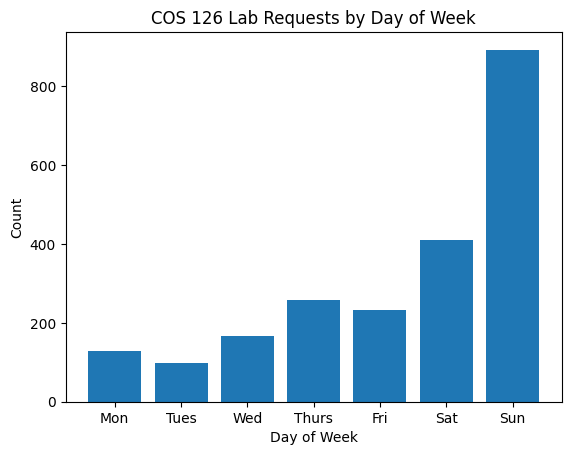

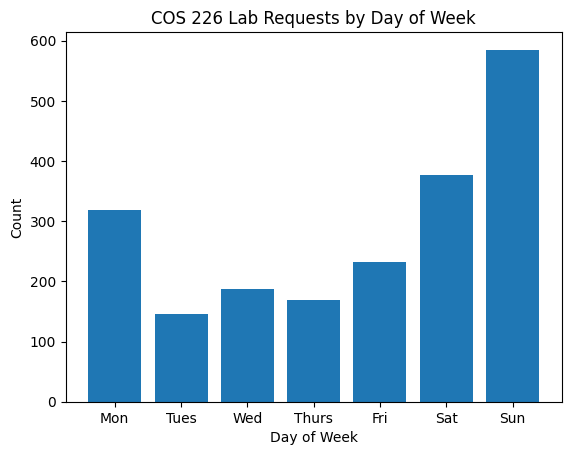

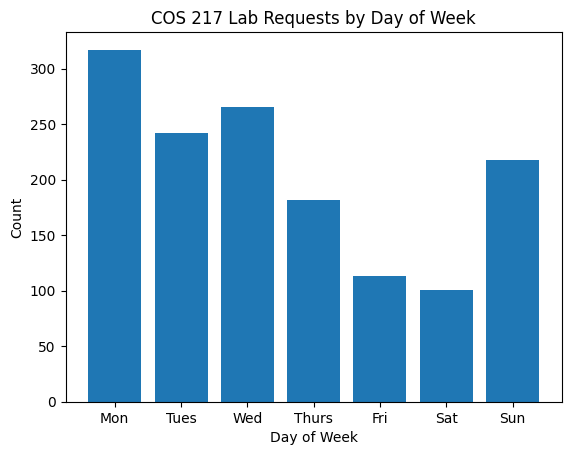

In [63]:
import datetime

start_date = datetime.date(year=2023, month=9, day=1)
end_date = datetime.date(year=2023, month=12, day=31)
delta = datetime.timedelta(days=1)

# Separate counts for 126, 226, and 217
# Index 0 is Monday, 1 is Tuesday, ..., 6 is Sunday
day_of_week_count = {"126": [0] * 7, "226": [0] * 7, "217": [0] * 7}

curr_day = start_date
while curr_day <= end_date:
    curr_day_start = curr_day.strftime("%Y-%m-%dT00:00")
    curr_day_end = curr_day.strftime("%Y-%m-%dT23:59")

    for course_name in ["126", "226", "217"]:
        payload = {"created_after": curr_day_start, "created_before": curr_day_end, "course": course_name}
        result = requests.get(base_url + "requests/query/", auth=wsse_auth, params=payload)

        day_of_week_count[course_name][curr_day.weekday()] += result.json()["count"]

    curr_day += delta

# Construct bar plots
for course_name in ["126", "226", "217"]:
  labels = ("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")
  plt.bar(np.arange(len(labels)), day_of_week_count[course_name], align="center")
  plt.xticks(np.arange(len(labels)), labels)
  plt.ylabel("Count")
  plt.xlabel("Day of Week")
  plt.title(f"COS {course_name} Lab Requests by Day of Week")
  plt.show()

# Construct Bar Plots of Coursewide Number of Requests by Shift

Input the start and end dates of the data collection in `start_date` and `end_date`, respectively (two code blocks down). Note that the bar graph shows the total number of requests for each shift across the entire time period (for example the total number of requests for help on all Tuesdays from 9-11pm)

In [59]:
def get_count_for_day_and_time(curr_day_shift_start, curr_day_shift_end, curr_shift, curr_day):
  # Get the number of requests for each course based on the input shift and date
  for course_name in ["126", "226", "217"]:
      payload = {"created_after": curr_day_shift_start, "created_before": curr_day_shift_end, "course": course_name}
      result = requests.get(base_url + "requests/query/", auth=wsse_auth, params=payload)
      day_of_week_count[course_name][curr_day.weekday()][curr_shift] += result.json()["count"]

In [60]:
def get_126_data():
  final_126_data = [];

  # Each item in day_of_week_count[course_name] is a dictionary with data for all
  # shifts, so on a specific day of the week, if a shift isn't offered the count
  # for that shift will be 0, so it should not be graphed. If this is confusing,
  # try printing out day_of_week_count
  for i in range(len(day_of_week_count["126"])):
    for count in day_of_week_count["126"][i].items():
      if(count[1] > 0):
        final_126_data.append(count[1])

  return final_126_data

def get_2xx_data():
  final_2xx_data = [];

  for i in range(len(day_of_week_count["226"])):
    for key, value in day_of_week_count["226"][i].items():
        # Sum COS 226 and 217 data
        if(value + day_of_week_count["217"][i][key] > 0):
          final_2xx_data.append(value + day_of_week_count["217"][i][key])

  return final_2xx_data

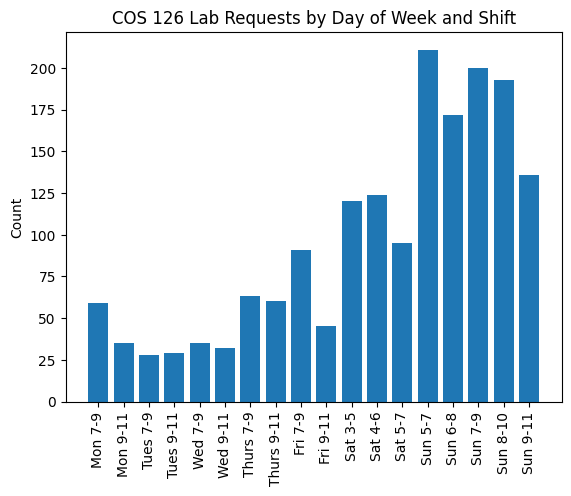

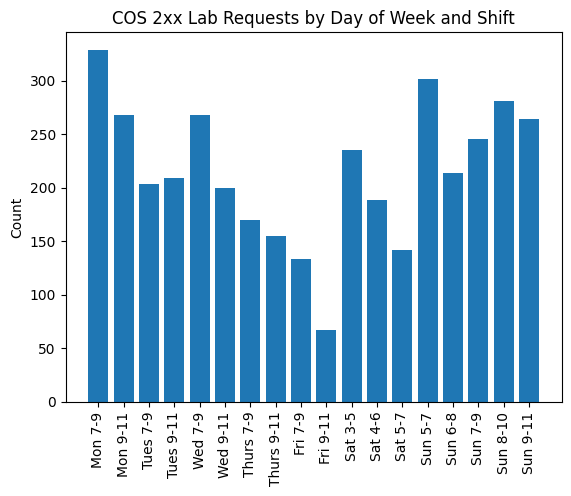

In [61]:
# look at the number of requests across the day of the week
import datetime
import copy

start_date = datetime.date(year=2023, month=9, day=1)
end_date = datetime.date(year=2023, month=12, day=10)
delta = datetime.timedelta(days=1)

d = {"3-5": 0, "4-6": 0, "5-7": 0, "6-8": 0, "7-9": 0, "8-10": 0, "9-11": 0}
# Separate counts for 126, 226, and 217
# Index 0 is Monday, 1 is Tuesday, ..., 6 is Sunday
day_of_week_count = {"126": [copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d)],
                     "226": [copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d)],
                     "217": [copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d), copy.deepcopy(d)]}

curr_day = start_date
while curr_day <= end_date:

    # Weekdays only have two shifts
    if(curr_day.weekday() <= 4):
      get_count_for_day_and_time(curr_day.strftime("%Y-%m-%dT00:00"), curr_day.strftime("%Y-%m-%dT21:00"), "7-9", curr_day)
      get_count_for_day_and_time(curr_day.strftime("%Y-%m-%dT21:00"), curr_day.strftime("%Y-%m-%dT23:30"), "9-11", curr_day)

    # Saturday
    if(curr_day.weekday() == 5):
      get_count_for_day_and_time(curr_day.strftime("%Y-%m-%dT00:00"), curr_day.strftime("%Y-%m-%dT17:00"), "3-5", curr_day)
      get_count_for_day_and_time(curr_day.strftime("%Y-%m-%dT16:00"), curr_day.strftime("%Y-%m-%dT18:00"), "4-6", curr_day)
      get_count_for_day_and_time(curr_day.strftime("%Y-%m-%dT17:00"), curr_day.strftime("%Y-%m-%dT19:30"), "5-7", curr_day)

    # Sunday
    if(curr_day.weekday() == 6):
      get_count_for_day_and_time(curr_day.strftime("%Y-%m-%dT00:00"), curr_day.strftime("%Y-%m-%dT19:30"), "5-7", curr_day)
      get_count_for_day_and_time(curr_day.strftime("%Y-%m-%dT18:00"), curr_day.strftime("%Y-%m-%dT20:00"), "6-8", curr_day)
      get_count_for_day_and_time(curr_day.strftime("%Y-%m-%dT19:00"), curr_day.strftime("%Y-%m-%dT21:00"), "7-9", curr_day)
      get_count_for_day_and_time(curr_day.strftime("%Y-%m-%dT20:00"), curr_day.strftime("%Y-%m-%dT22:00"), "8-10", curr_day)
      get_count_for_day_and_time(curr_day.strftime("%Y-%m-%dT21:00"), curr_day.strftime("%Y-%m-%dT23:30"), "9-11", curr_day)

    curr_day += delta

# Create bar plots
labels = ("Mon 7-9", "Mon 9-11", "Tues 7-9", "Tues 9-11", "Wed 7-9", "Wed 9-11",
          "Thurs 7-9", "Thurs 9-11", "Fri 7-9", "Fri 9-11", "Sat 3-5", "Sat 4-6",
          "Sat 5-7", "Sun 5-7", "Sun 6-8", "Sun 7-9", "Sun 8-10", "Sun 9-11")

final_126_data = get_126_data()
final_2xx_data = get_2xx_data()

for index, data in enumerate([final_126_data, final_2xx_data]):
  plt.bar(np.arange(len(labels)), data, align="center")
  plt.xticks(np.arange(len(labels)), labels)
  plt.ylabel("Count")
  if index == 0:
    plt.title("COS 126 Lab Requests by Day of Week and Shift")
  else:
    plt.title("COS 2xx Lab Requests by Day of Week and Shift")
  plt.xticks(rotation=90)
  plt.show()